In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import warnings
import gc
import psutil
warnings.filterwarnings('ignore')

In [2]:
# Set display options and style
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
sns.set(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Memory monitoring function
def monitor_memory_usage():
    """Monitor current memory usage"""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb

print(f"Initial memory usage: {monitor_memory_usage():.1f} MB")

# GPU Configuration (optional)
try:
    import torch
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')
        print("GPU not available, using CPU")
except ImportError:
    device = 'cpu'
    print("PyTorch not available, using CPU")

Initial memory usage: 243.4 MB
GPU available: Tesla T4


In [4]:
# Data Loading Functions
def load_tsv_gz_with_progress(path, usecols=None, sample_frac=0.5, description="Loading data"):
    """Load TSV.GZ file with progress tracking and sampling"""
    print(f"\n{description} from {os.path.basename(path)}...")
    print(f"Columns to load: {usecols}")

    # Count total lines for progress bar
    with gzip.open(path, 'rt') as f:
        total_lines = sum(1 for _ in f) - 1  # Subtract header

    print(f"Total records available: {total_lines:,}")
    sample_size = int(total_lines * sample_frac)
    print(f"Loading {sample_frac*100}% of data: {sample_size:,} records")

    # Load with progress bar
    with tqdm(total=sample_size, desc=description) as pbar:
        chunk_size = 50000
        chunks = []
        records_loaded = 0

        for chunk in pd.read_csv(path, sep='\t', compression='gzip',
                                 usecols=usecols, chunksize=chunk_size, low_memory=False):
            chunk_sample = chunk.sample(frac=sample_frac, random_state=42)
            chunks.append(chunk_sample)
            records_loaded += len(chunk_sample)
            pbar.update(len(chunk_sample))

            if records_loaded >= sample_size:
                break

    result = pd.concat(chunks, ignore_index=True)
    print(f"Successfully loaded: {len(result):,} records")
    return result

# File paths
BASICS_PATH = "/content/title.basics.tsv.gz"
RATINGS_PATH = "/content/title.ratings.tsv.gz"

In [5]:
# Load basics data (reduced sample for memory efficiency)
cols_basics = ['tconst', 'titleType', 'primaryTitle', 'startYear', 'genres', 'runtimeMinutes']
basics = load_tsv_gz_with_progress(BASICS_PATH, usecols=cols_basics,
                                  sample_frac=0.8,  # Increased sample size
                                  description="Loading movie basics")

# Load ratings data
ratings = load_tsv_gz_with_progress(RATINGS_PATH, usecols=['tconst', 'averageRating', 'numVotes'],
                                   sample_frac=0.8,  # Match basics sample
                                   description="Loading movie ratings")

print(f"Memory after loading: {monitor_memory_usage():.1f} MB")



Loading movie basics from title.basics.tsv.gz...
Columns to load: ['tconst', 'titleType', 'primaryTitle', 'startYear', 'genres', 'runtimeMinutes']
Total records available: 11,838,293
Loading 80.0% of data: 9,470,634 records


Loading movie basics: 100%|██████████| 9470634/9470634 [00:24<00:00, 390456.09it/s]


Successfully loaded: 9,470,634 records

Loading movie ratings from title.ratings.tsv.gz...
Columns to load: ['tconst', 'averageRating', 'numVotes']
Total records available: 1,602,402
Loading 80.0% of data: 1,281,921 records


Loading movie ratings: 1281922it [00:00, 1395609.33it/s]                             

Successfully loaded: 1,281,922 records
Memory after loading: 2686.4 MB


In [6]:
# Data Preprocessing
# Filter movies only
print("\nFiltering for movies and TV movies...")
initial_count = len(basics)
items = basics[basics['titleType'].isin(['movie', 'tvMovie'])].copy()
print(f"Filtered from {initial_count:,} to {len(items):,} movies/TV movies")

# Merge with ratings
print("\nMerging with ratings data...")
items = items.merge(ratings, on='tconst', how='left')
print(f"After merge: {len(items):,} records")

# Clean data
print("\nCleaning data...")
with tqdm(total=5, desc="Data cleaning steps") as pbar:
    items['genres'] = items['genres'].fillna('Unknown')
    pbar.update(1)

    items['startYear'] = pd.to_numeric(items['startYear'], errors='coerce')
    pbar.update(1)

    items['runtimeMinutes'] = pd.to_numeric(items['runtimeMinutes'], errors='coerce')
    pbar.update(1)

    items['averageRating'] = items['averageRating'].fillna(items['averageRating'].mean())
    items['numVotes'] = items['numVotes'].fillna(0)
    pbar.update(1)

    # Remove extreme outliers
    items = items[items['startYear'].between(1900, 2024)]
    pbar.update(1)


Filtering for movies and TV movies...
Filtered from 9,470,634 to 699,522 movies/TV movies

Merging with ratings data...
After merge: 699,522 records

Cleaning data...


Data cleaning steps: 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


In [7]:
# MEMORY-EFFICIENT FILTERING - Keep only high-quality movies
print(f"\nApplying quality filters for memory efficiency...")
print(f"Before filtering: {len(items):,} movies")

# Filter for movies with sufficient data and quality
filtered_items = items[
    (items['numVotes'] >= 50) &  # At least 50 votes
    (items['averageRating'] >= 4.0) &  # Decent rating
    (items['averageRating'].notna()) &
    (items['genres'] != 'Unknown')
].copy()

# Keep top movies by popularity to further reduce memory usage
if len(filtered_items) > 25000:
    print(f"Further reducing dataset to top 25,000 most popular movies...")
    filtered_items = filtered_items.nlargest(25000, 'numVotes')

items = filtered_items
print(f"After filtering: {len(items):,} movies")
print(f"Memory after filtering: {monitor_memory_usage():.1f} MB")

# Force garbage collection
del basics, ratings, filtered_items
gc.collect()


Applying quality filters for memory efficiency...
Before filtering: 598,940 movies
Further reducing dataset to top 25,000 most popular movies...
After filtering: 25,000 movies
Memory after filtering: 2686.8 MB


30

In [8]:
print(f"\nDataset Overview:")
print(f"Total movies: {len(items):,}")
print(f"Unique titles: {items['primaryTitle'].nunique():,}")
print(f"Date range: {int(items['startYear'].min())} - {int(items['startYear'].max())}")

# Ratings statistics
print(f"\nRatings Statistics:")
print(f"Average rating: {items['averageRating'].mean():.2f}")
print(f"Rating range: {items['averageRating'].min():.1f} - {items['averageRating'].max():.1f}")
print(f"Highly rated movies (>= 8.0): {(items['averageRating'] >= 8.0).sum():,}")

# Top genres
print(f"\nTop 10 Genres:")
all_genres = items['genres'].str.split(',').explode().value_counts().head(10)
for genre, count in all_genres.items():
    print(f"  {genre}: {count:,}")


Dataset Overview:
Total movies: 25,000
Unique titles: 23,756
Date range: 1913 - 2024

Ratings Statistics:
Average rating: 6.42
Rating range: 4.0 - 9.3
Highly rated movies (>= 8.0): 1,053

Top 10 Genres:
  Drama: 14,386
  Comedy: 8,586
  Action: 4,477
  Romance: 4,447
  Crime: 4,295
  Thriller: 3,596
  Horror: 2,985
  Adventure: 2,829
  Mystery: 2,174
  Biography: 1,488


In [9]:
# Memory-Efficient Recommendation System Class
class MemoryEfficientRecommender:
    """
    Memory-efficient recommendation system using k-NN approach
    Avoids computing full similarity matrix
    """
    def __init__(self, n_neighbors=100):
        self.n_neighbors = n_neighbors
        self.vectorizer = None
        self.nn_model = None
        self.items = None
        self.indices = None
        self.X = None

    def fit(self, items_df):
        """Fit the recommendation model"""
        print(f"\n{'='*60}")
        print("PHASE 3: BUILDING RECOMMENDATION MODEL")
        print("="*60)

        print("Preparing data for modeling...")
        self.items = items_df.copy().reset_index(drop=True)

        # Create content features
        print("Creating content features...")
        with tqdm(total=4, desc="Feature engineering") as pbar:
            # Clean genres
            self.items['genres_clean'] = self.items['genres'].str.replace(',', ' ').str.strip()
            pbar.update(1)

            # Create decade feature
            self.items['decade'] = (self.items['startYear'] // 10 * 10).astype('Int64')
            self.items['decade_str'] = self.items['decade'].astype(str).replace('<NA>', 'unknown')
            pbar.update(1)

            # Combine content features
            self.items['content'] = (self.items['genres_clean'].fillna('') + ' ' +
                                   self.items['decade_str'].fillna('unknown'))
            pbar.update(1)

            # Create popularity score using IMDB weighted rating formula
            C = self.items['averageRating'].mean()
            m = self.items['numVotes'].quantile(0.75)

            def weighted_rating(row):
                v = row['numVotes']
                R = row['averageRating']
                return (v/(v+m) * R) + (m/(v+m) * C)

            self.items['popularity_score'] = self.items.apply(weighted_rating, axis=1)
            self.items['popularity_norm'] = MinMaxScaler().fit_transform(
                self.items[['popularity_score']]).flatten()
            pbar.update(1)

        # Create TF-IDF vectors
        print("Creating TF-IDF vectors...")
        self.vectorizer = TfidfVectorizer(
            token_pattern=r'[^\s]+',
            max_features=2000,  # Reduced for memory efficiency
            min_df=3,
            max_df=0.7,
            lowercase=True
        )

        self.X = self.vectorizer.fit_transform(self.items['content'].fillna('unknown'))
        print(f"TF-IDF matrix shape: {self.X.shape}")
        print(f"Matrix memory usage: {self.X.data.nbytes / 1024**2:.1f} MB")
        print(f"Vocabulary size: {len(self.vectorizer.vocabulary_):,} features")

        # Use NearestNeighbors instead of full similarity matrix
        print("Training NearestNeighbors model (memory-efficient approach)...")
        self.nn_model = NearestNeighbors(
            n_neighbors=min(self.n_neighbors, self.X.shape[0]),
            metric='cosine',
            algorithm='brute',  # More memory efficient for sparse matrices
            n_jobs=-1  # Use all CPU cores
        )
        self.nn_model.fit(self.X)

        # Create index mapping for titles
        self.indices = pd.Series(self.items.index,
                               index=self.items['primaryTitle']).drop_duplicates()

        print(f"Model fitted successfully!")
        print(f"Total movies in model: {len(self.items):,}")
        print(f"Memory usage after model training: {monitor_memory_usage():.1f} MB")

    def get_recommendations(self, title, topn=10, alpha=0.7, min_votes=50,
                          min_rating=5.0, year_weight=0.1):
        """Get movie recommendations using k-NN approach"""

        if title not in self.indices:
            print(f"Title '{title}' not found in database")
            # Search for similar titles
            similar_titles = self.items[
                self.items['primaryTitle'].str.contains(title, case=False, na=False)]
            if not similar_titles.empty:
                print("Did you mean one of these?")
                for i, similar_title in enumerate(similar_titles['primaryTitle'].head(5)):
                    year = similar_titles.iloc[i]['startYear']
                    year_str = f" ({int(year)})" if pd.notna(year) else ""
                    print(f"  {i+1}. {similar_title}{year_str}")
            return pd.DataFrame()

        # Get movie index and info
        idx = self.indices[title]
        target_movie = self.items.iloc[idx]

        print(f"\nGenerating recommendations for: '{title}'")
        print(f"Genre: {target_movie['genres']}")
        year_str = f"{int(target_movie['startYear'])}" if pd.notna(target_movie['startYear']) else 'Unknown'
        print(f"Year: {year_str}")
        print(f"Rating: {target_movie['averageRating']:.1f}/10 ({int(target_movie['numVotes']):,} votes)")

        # Get TF-IDF vector for target movie
        target_vector = self.X[idx]

        # Find similar movies using k-NN (memory efficient!)
        distances, indices_nn = self.nn_model.kneighbors(target_vector, n_neighbors=min(200, len(self.items)))

        # Convert cosine distances to similarities
        similarities = 1 - distances.flatten()
        movie_indices = indices_nn.flatten()

        # Create recommendation candidates
        rec_data = []
        for i, (movie_idx, similarity) in enumerate(zip(movie_indices, similarities)):
            if movie_idx == idx:  # Skip the target movie itself
                continue

            movie = self.items.iloc[movie_idx]
            if (movie['numVotes'] >= min_votes and
                movie['averageRating'] >= min_rating and
                pd.notna(movie['averageRating'])):

                # Calculate recency bonus
                current_year = 2024
                movie_year = movie['startYear'] if pd.notna(movie['startYear']) else 2000
                year_bonus = max(0, (movie_year - 1970) / (current_year - 1970)) * year_weight

                rec_data.append({
                    'title': movie['primaryTitle'],
                    'genres': movie['genres'],
                    'year': int(movie_year),
                    'runtime': int(movie['runtimeMinutes']) if pd.notna(movie['runtimeMinutes']) else 'N/A',
                    'avgRating': movie['averageRating'],
                    'numVotes': int(movie['numVotes']),
                    'similarity': similarity,
                    'popularity_norm': movie['popularity_norm'],
                    'year_bonus': year_bonus
                })

                if len(rec_data) >= topn * 3:  # Get extra candidates
                    break

        if not rec_data:
            print(f"No recommendations found with criteria: min_votes={min_votes}, min_rating={min_rating}")
            return pd.DataFrame()

        # Create recommendations DataFrame
        recs_df = pd.DataFrame(rec_data)

        # Calculate final score combining content similarity, popularity, and recency
        recs_df['final_score'] = (alpha * recs_df['similarity'] +
                                 (1-alpha) * recs_df['popularity_norm'] +
                                 recs_df['year_bonus'])

        # Sort by final score and return top recommendations
        final_recs = recs_df.sort_values('final_score', ascending=False).head(topn)

        return final_recs[['title', 'genres', 'year', 'runtime', 'avgRating',
                          'numVotes', 'similarity', 'final_score']]

In [10]:
# Initialize and train the recommendation system
recommender = MemoryEfficientRecommender(n_neighbors=100)
recommender.fit(items)

print(f"\nFinal memory usage: {monitor_memory_usage():.1f} MB")


PHASE 3: BUILDING RECOMMENDATION MODEL
Preparing data for modeling...
Creating content features...


Feature engineering: 100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

Creating TF-IDF vectors...
TF-IDF matrix shape: (25000, 36)
Matrix memory usage: 0.6 MB
Vocabulary size: 36 features
Training NearestNeighbors model (memory-efficient approach)...
Model fitted successfully!
Total movies in model: 25,000
Memory usage after model training: 2177.4 MB

Final memory usage: 2177.4 MB


In [11]:
# Testing the Recommendation System
# Get popular movies for testing
popular_movies = items[items['numVotes'] > 500].sort_values('numVotes', ascending=False)
test_movies = popular_movies.head(10)['primaryTitle'].tolist()

print("Available popular movies for testing:")
for i, movie in enumerate(test_movies[:5], 1):
    movie_info = items[items['primaryTitle'] == movie].iloc[0]
    year = int(movie_info['startYear']) if pd.notna(movie_info['startYear']) else 'N/A'
    print(f"{i}. {movie} ({year}) - Rating: {movie_info['averageRating']:.1f}")


Available popular movies for testing:
1. The Dark Knight (2008) - Rating: 9.1
2. Fight Club (1999) - Rating: 8.8
3. Forrest Gump (1994) - Rating: 8.8
4. Interstellar (2014) - Rating: 8.7
5. Pulp Fiction (1994) - Rating: 8.8



Generating recommendations for: 'The Dark Knight'
Genre: Action,Crime,Drama
Year: 2008
Rating: 9.1/10 (3,058,233 votes)

Top 10 Recommendations:
----------------------------------------------------------------------------------------------------
21. 3:10 to Yuma                             (2007) Rating: 7.6 Votes: 344,993 Score: 0.969
 7. A History of Violence                    (2005) Rating: 7.4 Votes: 266,759 Score: 0.953
15. A Bittersweet Life                       (2005) Rating: 7.5 Votes: 45,561 Score: 0.947
 5. Pudhu Pettai                             (2006) Rating: 8.4 Votes:  8,923 Score: 0.946
23. Virumandi                                (2004) Rating: 8.4 Votes:  8,960 Score: 0.942
11. The Girl Who Played with Fire            (2009) Rating: 7.1 Votes: 100,546 Score: 0.940
13. Kaminey                                  (2009) Rating: 7.4 Votes: 18,708 Score: 0.938
 9. Unnaipol Oruvan                          (2009) Rating: 7.9 Votes:  6,374 Score: 0.932
17. Infernal Affairs I

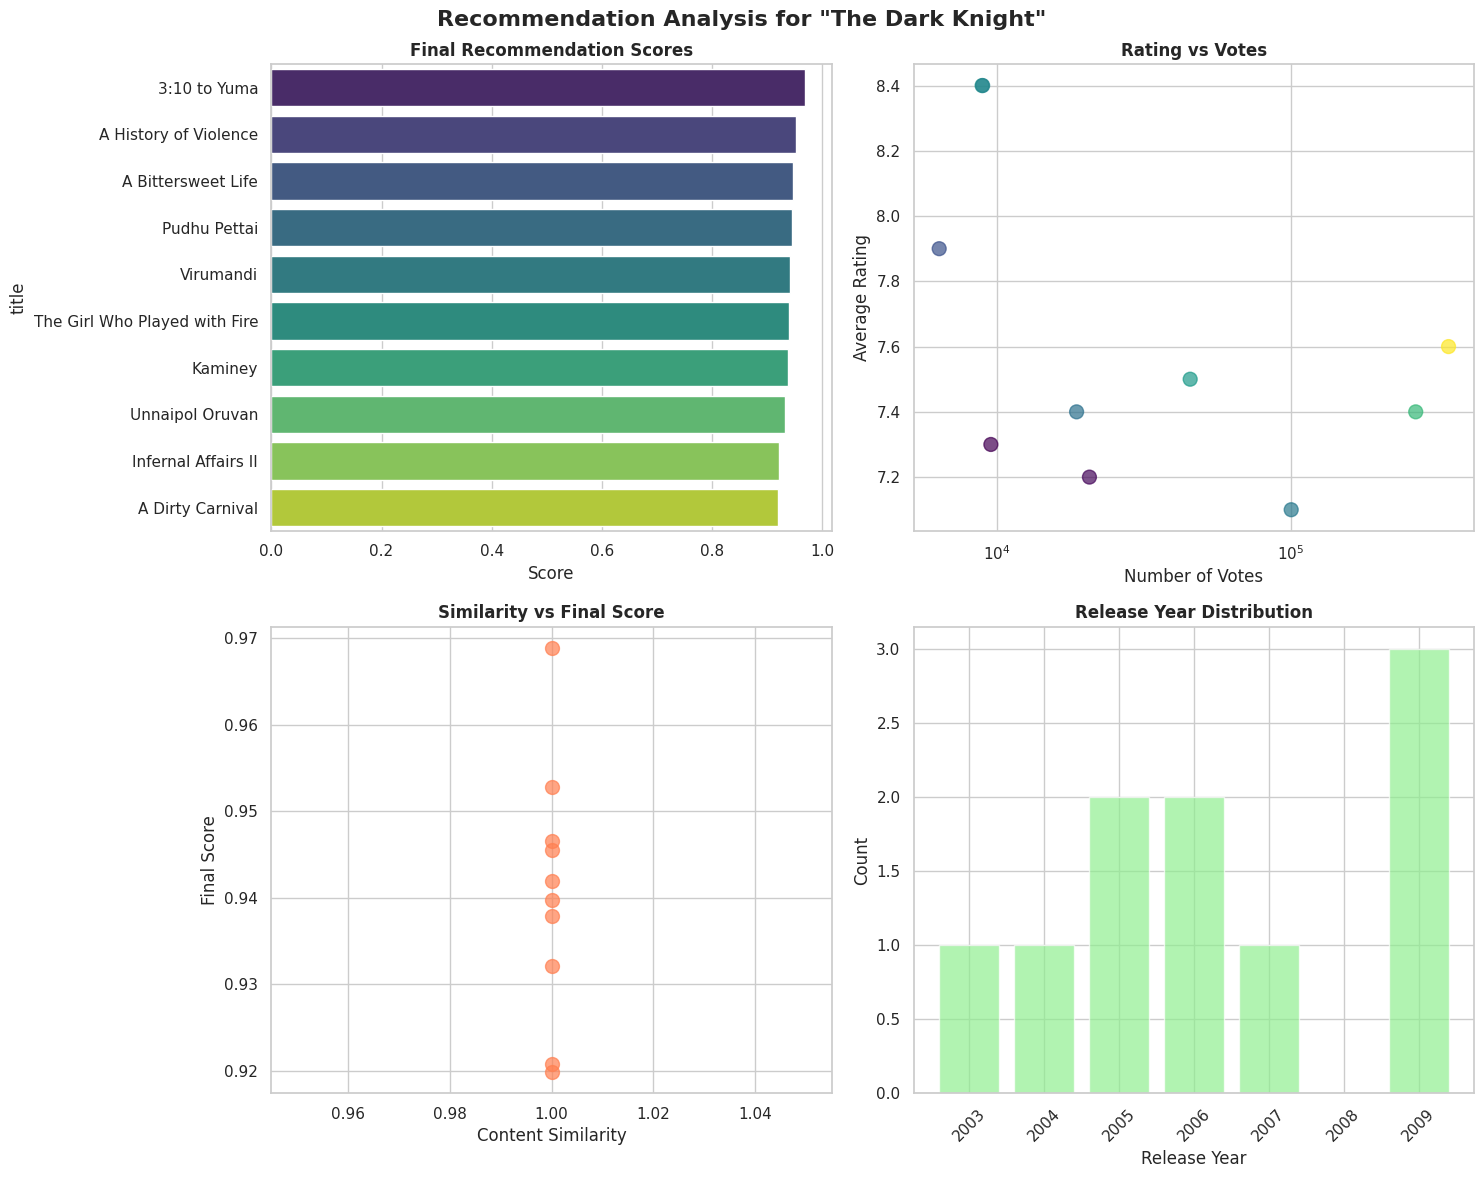

In [13]:
# Test with first movie
test_title = test_movies[0] # Define test_title using the first movie in the list

recommendations = recommender.get_recommendations(
    title=test_title,
    topn=10,
    alpha=0.7,
    min_votes=50,
    min_rating=6.0
)

if not recommendations.empty:
    print(f"\nTop 10 Recommendations:")
    print("-" * 100)
    for idx, rec in recommendations.iterrows():
        print(f"{idx+1:2d}. {rec['title']:<40} ({rec['year']}) "
              f"Rating: {rec['avgRating']:.1f} "
              f"Votes: {rec['numVotes']:>6,} "
              f"Score: {rec['final_score']:.3f}")

# Visualization of Results
if not recommendations.empty:
    print(f"\n{'='*60}")
    print("RECOMMENDATION ANALYSIS VISUALIZATION")
    print("="*60)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Recommendation Analysis for "{test_title}"', fontsize=16, fontweight='bold')

    # 1. Recommendation scores
    top_10 = recommendations.head(10)
    sns.barplot(data=top_10, x='final_score', y='title', palette='viridis', ax=axes[0,0])
    axes[0,0].set_title('Final Recommendation Scores', fontweight='bold')
    axes[0,0].set_xlabel('Score')

    # 2. Rating vs Votes
    axes[0,1].scatter(top_10['numVotes'], top_10['avgRating'],
                     s=100, alpha=0.7, c=top_10['final_score'], cmap='viridis')
    axes[0,1].set_xlabel('Number of Votes')
    axes[0,1].set_ylabel('Average Rating')
    axes[0,1].set_title('Rating vs Votes', fontweight='bold')
    axes[0,1].set_xscale('log')

    # 3. Similarity vs Final Score
    axes[1,0].scatter(top_10['similarity'], top_10['final_score'],
                     s=100, alpha=0.7, color='coral')
    axes[1,0].set_xlabel('Content Similarity')
    axes[1,0].set_ylabel('Final Score')
    axes[1,0].set_title('Similarity vs Final Score', fontweight='bold')

    # 4. Year distribution
    year_counts = top_10['year'].value_counts().sort_index()
    axes[1,1].bar(year_counts.index, year_counts.values, alpha=0.7, color='lightgreen')
    axes[1,1].set_xlabel('Release Year')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_title('Release Year Distribution', fontweight='bold')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [14]:
# System Performance Analysis

print(f"\n1. MODEL STATISTICS")

print(f"Total movies in dataset: {len(items):,}")
print(f"TF-IDF vocabulary size: {len(recommender.vectorizer.vocabulary_):,}")
print(f"Final memory usage: {monitor_memory_usage():.1f} MB")
print(f"k-NN neighbors: {recommender.n_neighbors}")

if not recommendations.empty:
    print(f"\n2. RECOMMENDATION QUALITY")
    print("-" * 40)
    print(f"Average recommendation rating: {recommendations['avgRating'].mean():.2f}")
    print(f"Average recommendation votes: {recommendations['numVotes'].mean():,.0f}")
    print(f"Average content similarity: {recommendations['similarity'].mean():.4f}")



1. MODEL STATISTICS
Total movies in dataset: 25,000
TF-IDF vocabulary size: 36
Final memory usage: 2168.9 MB
k-NN neighbors: 100

2. RECOMMENDATION QUALITY
----------------------------------------
Average recommendation rating: 7.62
Average recommendation votes: 83,107
Average content similarity: 1.0000
